## Import libraries & set up env

In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
from flax import linen as nn
from typing import Sequence
import jax
from jax import vmap, jit   
import os
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import (SVI, Trace_ELBO, autoguide, init_to_median, NUTS, MCMC, TraceMeanField_ELBO)
import pandas as pd
import pickle 
from numpyro.contrib.module import random_flax_module, flax_module
# from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.util import Predictive, log_density 
from sklearn.model_selection import train_test_split

#%% Environment and/or CUDA commands
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ['XLA_FLAGS']="--xla_gpu_force_compilation_parallelism=1"
numpyro.enable_x64(use_x64=True)
path = os.getcwd()
os.chdir(path)

## Read Data

(382, 19)
(382, 44)


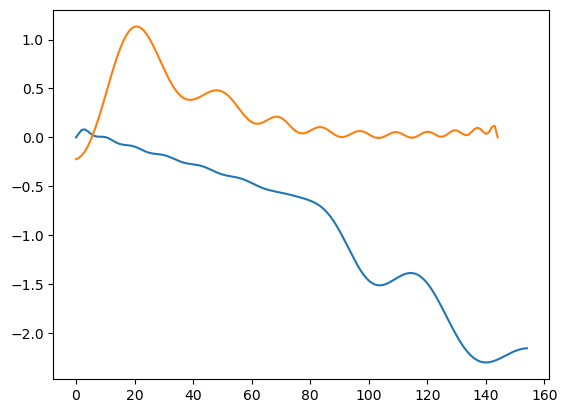

In [44]:
rng_key = random.PRNGKey(0)
num_warmup = 2000
num_samples = 1000
num_chains = 1 
init_strategy = init_to_median(num_samples=10) 
thinning = 2  

xdata = pd.read_csv('./Data/ProofOfConcept_BNN_train.csv',header=None)
ydata = pd.read_csv('./Data/ProofOfConcept_BNN_values.csv',header=None)
airfoilName = pd.read_csv('./Data/ProofOfConcept_BNN_ref.csv',header=None)
airfoilName = np.array(airfoilName.values.reshape((-1,1)))
x = xdata.values.T
y = ydata.values.T


def airfoil_train_test_split(X, Y, test_size, random_state, printChoice=False):
    np.random.seed(random_state) 
    airfoilsNum = np.unique(airfoilName).shape[0]
    airfoilsUnique = np.unique(airfoilName).flatten()
    case_indexing = np.arange(0, airfoilsNum) # Create index of unique cases in X 
    test_draws_indexing = np.sort(np.random.choice(case_indexing, size=int(airfoilsNum*test_size)))
    train_draws_indexing = np.sort(np.delete(case_indexing, test_draws_indexing))
    
    if printChoice:
        print(test_draws_indexing)

    for i in range(0, train_draws_indexing.shape[0]):
        ind = np.argwhere(airfoilName.flatten()==airfoilsUnique[train_draws_indexing[i]]).flatten()
        if i == 0:
            x_train = X[ind, :]
            y_train = Y[ind, :]
        else :
            x_train = np.vstack((x_train, X[ind, :]))# x_train[i*num_per_case:i*num_per_case+num_per_case , :] = X[train_draws_indexing[i]*num_per_case:train_draws_indexing[i]*num_per_case+num_per_case, :]
            y_train = np.vstack((y_train, Y[ind, :]))
        # y_train[i*num_per_case:i*num_per_case+num_per_case] = Y[train_draws_indexing[i]*num_per_case:train_draws_indexing[i]*num_per_case+num_per_case]
    
    for j in range(0, test_draws_indexing.shape[0]):
        ind2 = np.argwhere(airfoilName.flatten()==airfoilsUnique[test_draws_indexing[j]]).flatten()
        if j == 0:
            x_test = X[ind2, :]
            y_test = Y[ind2, :]
        else :
            x_test = np.vstack((x_test, X[ind2, :]))# x_train[i*num_per_case:i*num_per_case+num_per_case , :] = X[train_draws_indexing[i]*num_per_case:train_draws_indexing[i]*num_per_case+num_per_case, :]
            y_test = np.vstack((y_test, Y[ind2, :]))
        
    return x_train, x_test, y_train, y_test 
trainPerc = 0.7
xTrain, xTest, yTrain, yTest = airfoil_train_test_split(x, y, test_size = 1-trainPerc, random_state=831, printChoice=False)
afTrain, afTest, yTrain, yTest = airfoil_train_test_split(airfoilName, y, test_size = 1-trainPerc, random_state=831)


# Convert 
# plt.plot(yTrain[10,:])

def convert_Chebyshev(X, Y, degree):
    from numpy.polynomial import chebyshev
    # x location, Cb upper and lower
    new_data_x = np.zeros((X.shape[0], (degree+1)*2+300+1))#np.zeros((Y.flatten().shape[0], (degree+1)*2+2))
    new_data_Cp = np.zeros((Y.flatten().shape))
    counter = 0
    for i in range(X.shape[0]):
        zeroLoc = np.argwhere(np.diff(xTrain[0,:300])<= 0.0)[-1][0]
        # Obtain upper surface
        xc_u = X[i, :zeroLoc+1] # airfoil x, spans from 0 to 1 
        xc_l = X[i, zeroLoc+1:300] 
        yc_u = X[i, 300:300+zeroLoc+1] # airfoil thickness
        yc_l = X[i, 300+zeroLoc+1:300+300]
        Cp_u = Y[i, :zeroLoc+1]
        Cp_l = Y[i, zeroLoc+1:]
        AoA = X[i, -1] # angle of attack

        xc_temp_u = xc_u*2+-1 # Expand to -1 to 1 range for cheby
        xc_temp_l = xc_l*2+-1
        fit_u = chebyshev.Chebyshev.fit(xc_temp_u, Cp_u, degree)
        fit_l = chebyshev.Chebyshev.fit(xc_temp_l, Cp_l, degree)
        
        # for j in range(0, 300):
        #     if j < zeroLoc:
        #         xloc_value = -X[i, j] # correcting training data x cuz me dumb
        #     else : 
        #         xloc_value = X[i, j]
                
        values = np.hstack((fit_u.coef, fit_l.coef, xc_u, xc_l, AoA))
        new_data_x[i, :] = values
        #    new_data_Cp[counter] = Y[i, j]
        #    counter += 1 
            
        # new_data_x[] = np.hstack((coeffs, xLoc, alpha))
        # use this if u wanna evaluate
        out_u = np.polynomial.chebyshev.chebval(xc_temp_u, fit_u.coef)
        out_l = np.polynomial.chebyshev.chebval(xc_temp_l, fit_l.coef)
        plt.plot(xc_u, out_u)
        plt.plot(xc_l, out_l)
    return new_data_x

def CST_fit(x, y, degree):
    import scipy
    zeroLoc = np.argwhere(np.diff(x)<= 0.0)[-1][0]
    x_u = x[:zeroLoc+1].flatten()
    x_l = x[zeroLoc+1:].flatten()
    y_u = y[:zeroLoc+1].flatten()
    y_l = y[zeroLoc+1:].flatten()
    design_matrix_u = np.zeros((x_u.shape[0], degree+1))
    design_matrix_l = np.zeros((x_l.shape[0], degree+1))
    for i in range(0,degree+1):
        design_matrix_u[:,i] = scipy.special.comb(N=degree,k=i*np.ones(x_u.shape)) \
            * (x_u**i*(1-x_u**(degree-i)))
        design_matrix_l[:,i] = scipy.special.comb(N=degree,k=i*np.ones(x_l.shape)) \
            * (x_l**i*(1-x_l**(degree-i)))
            
    # Solve for coefficients
    coeffs_yu = scipy.linalg.lstsq(design_matrix_u, y_u)[0]
    coeffs_yl = scipy.linalg.lstsq(design_matrix_l, y_l)[0]
    return (coeffs_yu, coeffs_yl), (design_matrix_u, design_matrix_l), (x_u, x_l)

def convert_Berstein(X, Y, deg):
    degree1 = deg[0]
    degree2 = deg[1]
    import scipy
    # Convert X to airfoil information
    new_data_x = np.zeros((X.shape[0], 2*(degree1+1)+1))#np.zeros((Y.flatten().shape[0], (degree+1)*2+2))
    new_data_Cp = np.zeros((X.shape[0], 2*(degree2+1))) 
    
        # Create design matrix 
    for i in range(X.shape[0]): # Loop through all cases 
        coeff_af, dmat_af, x_af = CST_fit(X[i,:300], X[i,300:600], degree1)
        AoA = X[i, -1]
        new_data_x[i,:] = np.hstack((coeff_af[0], coeff_af[1], AoA))
        
        coeff_Cp, dmat_Cp, x_Cp = CST_fit(X[i,:300], Y[i,:], degree2)
        new_data_Cp[i,:] = np.hstack((coeff_Cp[0], coeff_Cp[1]))

        # print(np.hstack((coeffs_u, coeffs_l)).shape)
    return new_data_x, new_data_Cp, (dmat_af, dmat_Cp)
xTrain, yTrain, a = convert_Berstein(xTrain, yTrain, [8, 21])
xTest, yTest, b = convert_Berstein(xTest, yTest, [8, 21])

print(xTrain.shape)
print(yTrain.shape)
plt.plot(a[1][0] @ yTrain[5,:22])
plt.plot(a[1][1] @ yTrain[5,22:])
# print(xTrain_backup[:2,:])

In [19]:
# MLP setup from flax
class MLP(nn.Module):
  layers: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.layers[:-1]:
      x = nn.tanh(nn.Dense(feat)(x))
    x = nn.Dense(self.layers[-1])(x) # 
    return x
  
def airfoil_Cp_predictor(x, y=None):
    mlp = random_flax_module(
        "mlp",
        MLP([300, 300, 18]),
        prior=dist.Normal(),
        input_shape=(x.shape[1],),
    )
  
    with numpyro.plate("obs", x.shape[0]):
        mu = mlp(x).squeeze() 
        sig = 0.02 # Fake standard dev for XFOIL data
        # numpyro.deterministic("y", mu, obs=y)
        numpyro.sample("y", dist.Normal(mu, sig).to_event(1), obs=y,)

#%% 
def nonlin(x):
    return nn.relu(x)

def model_bnn(X, Y=None, num_Neurons=[100, 10, 100], sigma_w=1):
    
  D_X, D_Y = X.shape[1], yTrain.shape[1]
  N = X.shape[0]
  # sample first layer (we put unit normal priors on all weights)
  w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, num_Neurons[0])), sigma_w*jnp.ones((D_X, num_Neurons[0]))))  # D_X D_H
  b1 = numpyro.sample("b1", dist.Normal(jnp.zeros((num_Neurons[0], 1)), sigma_w*jnp.ones((num_Neurons[0], 1))))  # D_H 1
  z1 = nonlin(jnp.matmul(X, w1) + jnp.transpose(b1))   # N D_H  <= first layer of activations

  # sample second layer
  w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((num_Neurons[0], num_Neurons[1])), sigma_w*jnp.ones((num_Neurons[0], num_Neurons[1]))))  # D_H D_H
  b2 = numpyro.sample("b2", dist.Normal(jnp.zeros((num_Neurons[1], 1)), sigma_w*jnp.ones((num_Neurons[1], 1))))  # D_H 1
  z2 = nonlin(jnp.matmul(z1, w2) + jnp.transpose(b2))  # N D_H  <= second layer of activations
  
  w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((num_Neurons[1], num_Neurons[2])), sigma_w*jnp.ones((num_Neurons[1], num_Neurons[2]))))  # D_H D_H
  b3 = numpyro.sample("b3", dist.Normal(jnp.zeros((num_Neurons[2], 1)), sigma_w*jnp.ones((num_Neurons[2], 1))))  # D_H 1
  z3 = nonlin(jnp.matmul(z2, w3) + jnp.transpose(b3))  # N D_H  <= thrid layer of activations
  
  wf = numpyro.sample("wf", dist.Normal(jnp.zeros((num_Neurons[2], D_Y)), sigma_w*jnp.ones((num_Neurons[2], D_Y))))  # D_H D_H
  bf = numpyro.sample("bf", dist.Normal(jnp.zeros((D_Y, 1)), sigma_w*jnp.ones((D_Y, 1))))  # D_H 1
  zf = jnp.matmul(z3, wf) + jnp.transpose(bf)  # N D_H  <= f layer of activations
 
  with numpyro.plate("obs", N):
    # note we use to_event(1) because each observation has shape (1,)
    numpyro.sample("Y", dist.Normal(zf, 1e-8).to_event(1), obs=Y) # 1e-4
    # add penalty promoting smoothness
    # numpyro.factor("penalty-smooth", smoothness_penalty(zf, 10))

def run_inference(XX, yy):
  start = time.time()
  kernel = NUTS(model_bnn, 
                init_strategy=init_to_median(num_samples=10))
  mcmc = MCMC(
      kernel, num_warmup = num_warmup, \
      num_samples = num_samples, \
      num_chains = num_chains, \
      thinning = thinning, \
      progress_bar=True
  )
  key = random.PRNGKey(0)
  mcmc.run(key, XX, yy)
  mcmc.print_summary()
  print("\nMCMC elapsed time:", time.time() - start)
  return mcmc.get_samples()

def smoothness_penalty(val, scale):
    # Compute the gradient of the latent function
    grad = jnp.gradient(jnp.gradient(val.reshape((-1,150),order='C'),axis=1),axis=1)
    #yTest.reshape((-1,150),order='C'
    # Compute the penalty term based on the gradient
    penalty = jnp.sum(jnp.square(grad))  # Example: L2 penalty
    
    return -scale*penalty
  
def weight_penalty(val, scale=1):
  penalty = jnp.sum(jnp.square(val))
  return -scale*penalty

  

### Read data and set up training

  0%|          | 0/200000 [00:00<?, ?it/s]2024-02-02 15:21:41.634853: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

100%|██████████| 200000/200000 [01:34<00:00, 2113.84it/s, init loss: 346756607782574142521344.0000, avg. loss [190001-200000]: 264190572053916128.0000]
2024-02-02 15:23:50.971000: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-02 15:23:51.066967: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

20

Text(0, 0.5, 'Loss')

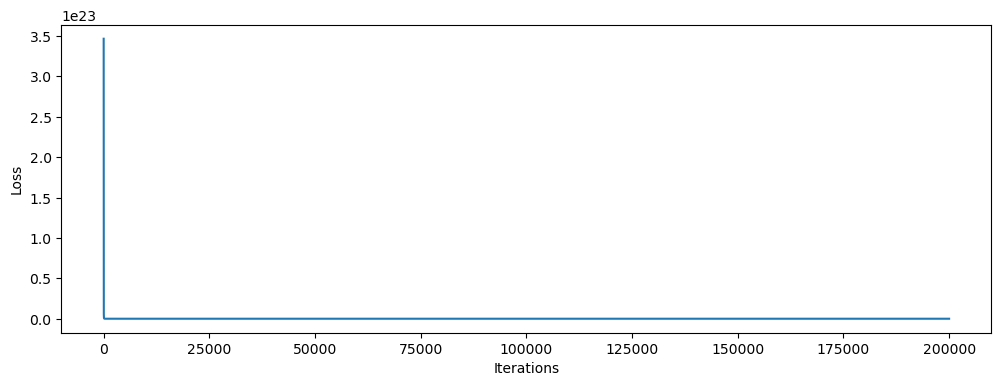

In [46]:
# Train and plot loss
# loadPrevious = False
# if loadPrevious:
#     with open('/home/hlee981/Documents/Lift Distribution/Onera M6/Prior Generator Model/MLP_XFOIL_workingPrototype.pkl', 'rb') as file:
#         loadInfo = pickle.load(file)
#         svi_result = loadInfo[0]
#         guide = autoguide.AutoDelta(model=airfoil_Cp_predictor)

trainNew = True
if trainNew == True:
    # Train new SVI model
    total_iterations = 0
    svi_init_state = None
    guide = autoguide.AutoDelta(model=model_bnn)
    optimizer = numpyro.optim.Adam(step_size = 0.001)
    svi = SVI(model_bnn, guide, optimizer, loss=Trace_ELBO())
elif trainNew == False:
    # Continue the save
    print('Continuing from previous SVI state...') 
    # optimizer = numpyro.optim.Minimize(step_size = 0.001)
    svi.optimizer = numpyro.optim.Adam(step_size = 0.0001)
    svi_init_state = svi_result.state
else:
     raise ValueError('lol no')

n_samples = 10000*20
total_iterations += n_samples
svi_result = svi.run(rng_key, n_samples, xTrain, (yTrain-np.mean(yTrain,axis=0))/1e8, [100, 20, 100], init_state=svi_init_state) # -np.mean(yTrain,axis=0)
plt.figure(figsize=(12,4))
plt.plot(svi_result.losses)
plt.xlabel('Iterations')
plt.ylabel('Loss') 

# test = run_inference(xTrain, yTrain-np.mean(yTrain, axis=0))

In [47]:

params = svi_result.params
# get posterior predictive (deterministics and likelihood)
posterior_predictive = Predictive(
    model=model_bnn, guide=guide, params=params, num_samples= 500
)

rng_key, rng_subkey = random.split(key=rng_key)  

# plt.plot(yTest.reshape((-1,150),order='C')[1])

In [ ]:
architecture = 'MLP'
num_neurons = '300'
noise_value = 0.02
additional_notes = 'XFOIL prototype'
meta = [architecture, num_neurons, noise_value, n_samples, additional_notes]
data = [xTrain, xTest, afTrain, afTest, yTrain, yTest]
saveData = [svi_result, guide, data, meta]

saveData = {} 
saveData['model'] = airfoil_Cp_predictor
saveData['params'] = svi_result.params
saveData['guide'] = guide
saveData['data'] = data
saveData['meta'] = meta 
# with open('/home/hlee981/Documents/Lift Distribution/Onera M6/Prior Generator Model/quickload.pkl', 'wb') as file:
#         pickle.dump(saveData, file)

## Run validation cases

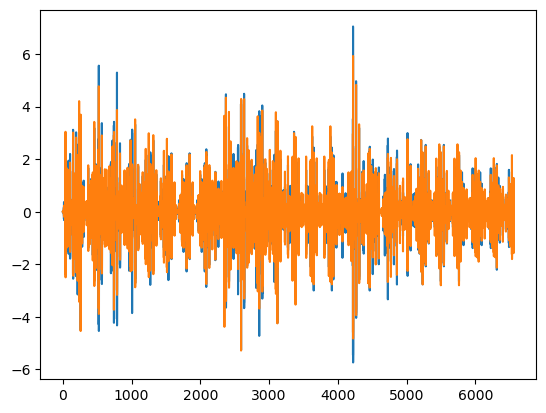

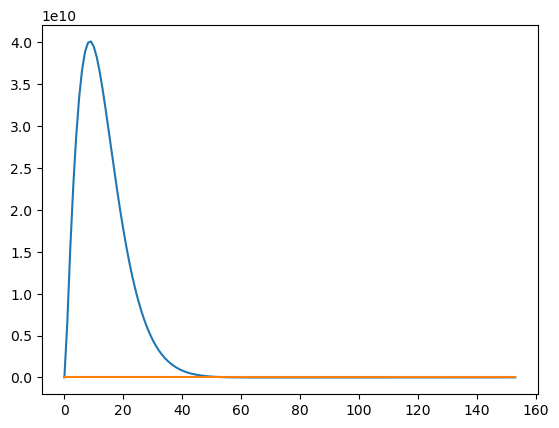

In [48]:
post_pred_test = posterior_predictive(rng_subkey, xTest)
post_pred_train = posterior_predictive(rng_subkey, xTrain)
mu = np.mean(np.squeeze(post_pred_test['Y']), axis=0)#+np.mean(yTrain,axis=0)
# plt.plot(mu[10,:])
# plt.plot(yTest[10,:])

plt.plot((yTest-np.mean(yTrain,axis=0)).flatten()/1e8)
plt.plot(mu.flatten())
# plt.plot(xTest[10,21*2:-1])
# plt.plot(xTest[10,21*2:-1], yTest[10])
# print(b[0].shape)
plt.figure()
plt.plot(b[1][0] @ (mu[25,:22])*1e8)
plt.plot(b[1][0] @ (yTest[25,:22]))
# plt.plot(b[0] @ yTest[10,9:])
# plt.show()

# plt.plot(np.squeeze(post_pred_test['Y'][0,44,:]))
# plt.plot(yTest[44]-np.mean(yTrain,axis=0),'k--',alpha=0.5)
# plt.figure()

# plt.plot(np.squeeze(post_pred_train['Y'][0,10,:])+np.mean(yTrain,axis=0))
# plt.plot(yTrain[10],'k--',alpha=0.5)

Case 1: Clark Y

2024-02-02 15:07:26.473941: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-02 15:07:26.762326: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-02 15:07:26.943790: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



ValueError: x and y must have same first dimension, but have shapes (300,) and (24,)

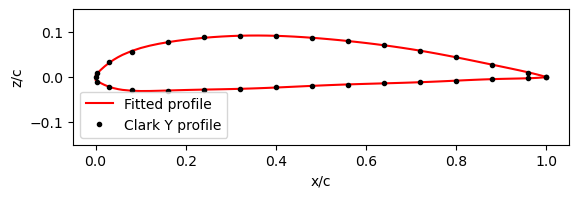

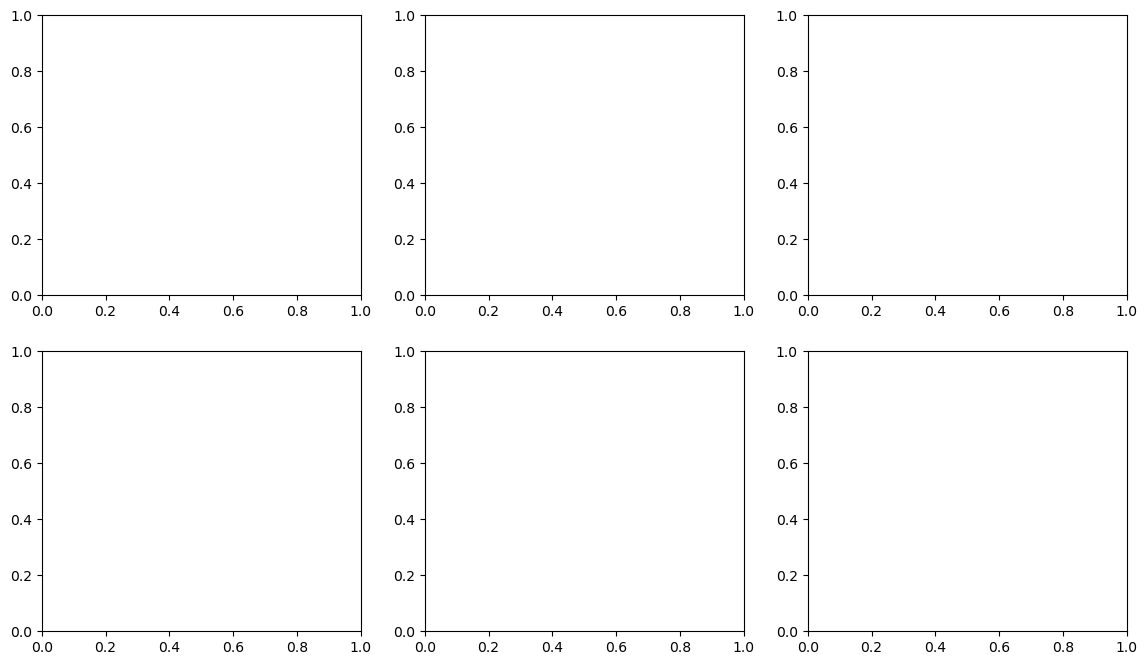

In [11]:
yMean = np.mean(yTrain, axis=0)

# Read Clark Y Coordinates
fileLoc_profile = '/home/hlee981/Documents/Lift Distribution/BNN Airfoil Prior Generator/Validation Data/af_profiles/'
fileLoc_data = '/home/hlee981/Documents/Lift Distribution/BNN Airfoil Prior Generator/Validation Data/af_pressure_dist/'
clark_y = np.loadtxt(fileLoc_profile+"clark_y.txt", delimiter=' ')

coeffs, dmatrix, new_x = CST_fit(clark_y[:,0], clark_y[:,1], 8)
plt.figure()
plt.plot(new_x[0], dmatrix[0] @ coeffs[0], 'r-', label = 'Fitted profile')
plt.plot(new_x[1], dmatrix[1] @ coeffs[1], 'r-')
plt.plot(clark_y[::4,0], clark_y[::4,1], 'k.', label = 'Clark Y profile')
plt.xlabel('x/c')
plt.ylabel('z/c')
plt.axis('scaled')
plt.ylim([-0.15,0.15])
plt.legend()

# Case a) a = 0 deg
f_case1, ax_case1 = plt.subplots(2,3,figsize=(14,8))
case1a = np.hstack((coeffs[0], coeffs[1], 0)).reshape((1,-1))
case1a_results = posterior_predictive(rng_subkey, case1a)
ax_case1[0,0].plot(np.abs(np.linspace(-1,1,300)), np.mean(np.squeeze(case1a_results['Y'][:,0,:]),axis=0)+yMean)

    # Validation data 
case1a_val = np.loadtxt(fileLoc_data+"clarkY_0.txt", delimiter=' ')
ax_case1[0,0].plot(case1a_val[:,0], case1a_val[:,2],'k--', label='XFOIL')
ax_case1[0,0].set_xlabel('x/c [1]')
ax_case1[0,0].set_ylabel('$C_p$ [1]')
ax_case1[0,0].title.set_text('0 deg')
ax_case1[0,0].set_ylim([-1.6, 1.1])
ax_case1[0,0].invert_yaxis()

# Case b) a = 1 deg
    # Validation data 
case1b_val = np.loadtxt(fileLoc_data+"clarkY_1.txt", delimiter=' ')
ax_case1[0,1].plot(case1b_val[:,0], case1b_val[:,2],'k--', label='XFOIL')
ax_case1[0,1].set_xlabel('x/c [1]')
ax_case1[0,1].set_ylabel('$C_p$ [1]')
ax_case1[0,1].title.set_text('1 deg')
ax_case1[0,1].set_ylim([-1.6, 1.1])
ax_case1[0,1].invert_yaxis()

# Case c) a = 2 deg
    # Validation data 
case1c_val = np.loadtxt(fileLoc_data+"clarkY_2.txt", delimiter=' ')
ax_case1[0,2].plot(case1c_val[:,0], case1c_val[:,2],'k--', label='XFOIL')
ax_case1[0,2].set_xlabel('x/c [1]')
ax_case1[0,2].set_ylabel('$C_p$ [1]')
ax_case1[0,2].title.set_text('2 deg')
ax_case1[0,2].set_ylim([-1.6, 1.1])
ax_case1[0,2].invert_yaxis()

# Case d) a = 3 deg
    # Validation data 
case1d_val = np.loadtxt(fileLoc_data+"clarkY_3.txt", delimiter=' ')
ax_case1[1,0].plot(case1d_val[:,0], case1d_val[:,2],'k--', label='XFOIL')
ax_case1[1,0].set_xlabel('x/c [1]')
ax_case1[1,0].set_ylabel('$C_p$ [1]')
ax_case1[1,0].title.set_text('3 deg')
ax_case1[1,0].set_ylim([-1.6, 1.1])
ax_case1[1,0].invert_yaxis()

# Case e) a = 4 deg
    # Validation data 
case1e_val = np.loadtxt(fileLoc_data+"clarkY_4.txt", delimiter=' ')
ax_case1[1,1].plot(case1e_val[:,0], case1e_val[:,2],'k--', label='XFOIL')
ax_case1[1,1].set_xlabel('x/c [1]')
ax_case1[1,1].set_ylabel('$C_p$ [1]')
ax_case1[1,1].title.set_text('4 deg')
ax_case1[1,1].set_ylim([-1.6, 1.1])
ax_case1[1,1].invert_yaxis()

# Case f) a = 5 deg
    # Validation data 
case1f_val = np.loadtxt(fileLoc_data+"clarkY_5.txt", delimiter=' ')
ax_case1[1,2].plot(case1f_val[:,0], case1f_val[:,2],'k--', label='XFOIL')
ax_case1[1,2].set_xlabel('x/c [1]')
ax_case1[1,2].set_ylabel('$C_p$ [1]')
ax_case1[1,2].title.set_text('5 deg')
ax_case1[1,2].set_ylim([-1.6, 1.1])
ax_case1[1,2].invert_yaxis()

Case 2: Onera D

In [ ]:
# Read Clark Y Coordinates
fileLoc_profile = '/home/hlee981/Documents/Lift Distribution/BNN Airfoil Prior Generator/Validation Data/af_profiles/'
fileLoc_data = '/home/hlee981/Documents/Lift Distribution/BNN Airfoil Prior Generator/Validation Data/af_pressure_dist/'
onera_D = np.loadtxt(fileLoc_profile+"oneraD.txt", delimiter=' ')

coeffs, dmatrix, new_x = CST_fit(onera_D[:,0], onera_D[:,1], 8)
plt.figure()
plt.plot(new_x[0], dmatrix[0] @ coeffs[0], 'r-', label = 'Fitted profile')
plt.plot(new_x[1], dmatrix[1] @ coeffs[1], 'r-')
plt.plot(onera_D[::4,0], onera_D[::4,1], 'k.', label = 'Onera D profile')
plt.xlabel('x/c')
plt.ylabel('z/c')
plt.axis('scaled')
plt.ylim([-0.15,0.15])
plt.legend()

# Case a) a = 0 deg
f_case1, ax_case2 = plt.subplots(2,3,figsize=(14,8))
case2a = np.hstack((coeffs[0], coeffs[1], 0)).reshape((1,-1))
case2a_results = posterior_predictive(rng_subkey, case2a)
ax_case2[0,0].plot(np.abs(np.linspace(-1,1,300)), np.mean(np.squeeze(case2a_results['Y'][:,0,:]),axis=0)+yMean)

    # Validation data 
case2a_val = np.loadtxt(fileLoc_data+"oneraD_0.txt", delimiter=' ')
ax_case2[0,0].plot(case2a_val[:,0], case2a_val[:,2],'k--', label='XFOIL')
ax_case2[0,0].set_xlabel('x/c [1]')
ax_case2[0,0].set_ylabel('$C_p$ [1]')
ax_case2[0,0].title.set_text('0 deg')
ax_case2[0,0].set_ylim([-2.2, 1.1])
ax_case2[0,0].invert_yaxis()

# Case b) a = 1 deg
    # Validation data 
case2b_val = np.loadtxt(fileLoc_data+"oneraD_1.txt", delimiter=' ')
ax_case2[0,1].plot(case2b_val[:,0], case2b_val[:,2],'k--', label='XFOIL')
ax_case2[0,1].set_xlabel('x/c [1]')
ax_case2[0,1].set_ylabel('$C_p$ [1]')
ax_case2[0,1].title.set_text('1 deg')
ax_case2[0,1].set_ylim([-2.2, 1.1])
ax_case2[0,1].invert_yaxis()

# Case c) a = 2 deg
    # Validation data 
case2c_val = np.loadtxt(fileLoc_data+"oneraD_2.txt", delimiter=' ')
ax_case2[0,2].plot(case2c_val[:,0], case2c_val[:,2],'k--', label='XFOIL')
ax_case2[0,2].set_xlabel('x/c [1]')
ax_case2[0,2].set_ylabel('$C_p$ [1]')
ax_case2[0,2].title.set_text('2 deg')
ax_case2[0,2].set_ylim([-2.2, 1.1])
ax_case2[0,2].invert_yaxis()

# Case d) a = 3 deg
    # Validation data 
case2d_val = np.loadtxt(fileLoc_data+"oneraD_3.txt", delimiter=' ')
ax_case2[1,0].plot(case2d_val[:,0], case2d_val[:,2],'k--', label='XFOIL')
ax_case2[1,0].set_xlabel('x/c [1]')
ax_case2[1,0].set_ylabel('$C_p$ [1]')
ax_case2[1,0].title.set_text('3 deg')
ax_case2[1,0].set_ylim([-2.2, 1.1])
ax_case2[1,0].invert_yaxis()

# Case e) a = 4 deg
    # Validation data 
case2e_val = np.loadtxt(fileLoc_data+"oneraD_4.txt", delimiter=' ')
ax_case2[1,1].plot(case2e_val[:,0], case2e_val[:,2],'k--', label='XFOIL')
ax_case2[1,1].set_xlabel('x/c [1]')
ax_case2[1,1].set_ylabel('$C_p$ [1]')
ax_case2[1,1].title.set_text('4 deg')
ax_case2[1,1].set_ylim([-2.2, 1.1])
ax_case2[1,1].invert_yaxis()

# Case f) a = 5 deg
    # Validation data 
case2f_val = np.loadtxt(fileLoc_data+"oneraD_5.txt", delimiter=' ')
ax_case2[1,2].plot(case2f_val[:,0], case2f_val[:,2],'k--', label='XFOIL')
ax_case2[1,2].set_xlabel('x/c [1]')
ax_case2[1,2].set_ylabel('$C_p$ [1]')
ax_case2[1,2].title.set_text('5 deg')
ax_case2[1,2].set_ylim([-2.2, 1.1])
ax_case2[1,2].invert_yaxis()

In [ ]:
plt.plot()

## Relevant plots

BNN Architecture: Use the desktop version instead of using the PIBE ver.

Determine Normality

In [ ]:
# Reminder of BNN architecture
def airfoil_Cp_predictor(x, y=None):
    mlp = random_flax_module(
        "mlp",
        MLP([300, 300, 300]),
        prior=dist.Normal(),
        input_shape=(x.shape[1],),
    )
    with numpyro.plate("obs", x.shape[0]):
        mu = mlp(x).squeeze() 
        sig = 0.02 # Fake standard dev for XFOIL data
        numpyro.sample("y", dist.Normal(mu, sig).to_event(1), obs=y,)
        
# Samples from the posterior predictive 
numDraws = 5000
params = svi_result.params
prediction_sampler = Predictive(
    model=airfoil_Cp_predictor, guide=guide, params=params, num_samples= numDraws
)
MLP_draws = np.squeeze(prediction_sampler(rng_key, xTrain[81:82,:])['y'])
MLP_draws_mu = np.mean(MLP_draws, axis=0)
MLP_draws_sig = np.std(MLP_draws, axis=0)

# Samples from a true normal distribution with the determined mean and sigma
trueN_draws = np.squeeze(dist.Normal(loc=MLP_draws_mu, scale = MLP_draws_sig).sample(key = rng_key, sample_shape=(numDraws,)))
# For debugging - making sure the results are expected when distribution is not normal
debugN_draws = np.squeeze(dist.Cauchy(loc=MLP_draws_mu, scale = MLP_draws_sig).sample(key = rng_key, sample_shape=(numDraws,)))

import scipy
p = []
# Perform 2-sample KS test for all 300 points 
for i in range(0, MLP_draws.shape[1]):
    p_sample = MLP_draws[:,i] 
    q_sample = trueN_draws[:,i] 
    ks_result = scipy.stats.ks_2samp(p_sample, q_sample)
    p.append(ks_result.pvalue)  

# Null hypothesis: Two samples are same drawn from same distribution (P > 0.05)
# Alternative - 2-sided: Two samples are not from the identical distribution (P <= 0.05)
plt.plot(np.array(p)>=0.05,'.')
plt.xlabel('Neuron')
plt.ylabel('Distribution')
plt.yticks([0.0, 1.0], ['Is not Gaussian', 'Is Gaussian'])
plt.show()

In [ ]:
xt = x[120,:300]
yt = y[120,:300]
plt.plot(xt, yt)
coeffs_1, dmatrix_1, new_x = CST_fit(xt[100:150], yt[100:150], 21)
coeffs_2, dmatrix_2, new_x = CST_fit(xt[0:100], yt[:100], 21)
plt.plot(xt[100:149], dmatrix_1[0]@coeffs_1[0] )
plt.plot(xt[:99], dmatrix_2[0]@coeffs_2[0] )